In [1]:
import sklearn
print(sklearn.__version__)

1.3.2


In [298]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

#### 

#### Importando a base de dados feita com o script de coleta de dados a partir do Yahoofinance, atualmente para não pesar temos apenas 3 ativos. Mas podemos fazer todos ativos da bolsa disponível quando desejar.

In [299]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.282051,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.267754,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.260614,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.262399,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.267754,6445,ABEV3.SA


In [300]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26966 entries, 0 to 26965
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       26966 non-null  datetime64[ns]
 1   Open       26966 non-null  float64       
 2   High       26966 non-null  float64       
 3   Low        26966 non-null  float64       
 4   Close      26966 non-null  float64       
 5   Adj Close  26966 non-null  float64       
 6   Volume     26966 non-null  int64         
 7   Ticker     26966 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.6+ MB


#### Ordenando por data e ticker e pegando a diferença do dia anterior.

In [301]:
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by = ['Ticker','Date'], inplace = True)

price_data['change_in_price'] = price_data['Close'].diff()
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price
11747,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000
11748,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997
11749,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002
11750,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999
11751,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998


In [302]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    return np.sign(data.shift(-d) - data)



# Aplicando a suavização exponencial
alpha = 0.20
price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 10 dias
d = 10
price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.282051,985,ABEV3.SA,NaN,0.520882,-1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.267754,227,ABEV3.SA,-0.026404,0.515601,-1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.260614,1137,ABEV3.SA,-0.013185,0.508740,-1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.262399,606,ABEV3.SA,0.003296,0.503909,-1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.267754,6445,ABEV3.SA,0.009889,0.502023,-1.0


In [303]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1  # Substitui os 0 por -1
    return target



# Aplicando a suavização exponencial
alpha = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 10 dias
d = 10
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.282051,985,ABEV3.SA,NaN,0.520882,-1.0,0.520882,-1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.267754,227,ABEV3.SA,-0.026404,0.515601,-1.0,0.494478,1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.260614,1137,ABEV3.SA,-0.013185,0.508740,-1.0,0.481293,1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.262399,606,ABEV3.SA,0.003296,0.503909,-1.0,0.484589,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.267754,6445,ABEV3.SA,0.009889,0.502023,-1.0,0.494478,-1.0


In [304]:
# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-10)
price_data['Smoothed_Close_10'] = price_data.groupby('Ticker')['Smoothed_Close'].shift(-10)

#### Tirando a diferença do 'Smoothed_Close' na virada de um tick para outro.

In [305]:
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)

price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

price_data[price_data.isna().any(axis = 1)]

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.282051,985,ABEV3.SA,NaN,0.520882,-1.0,0.520882,-1.0,0.520882,0.499416
5725,2024-12-17,13.000000,13.190000,12.990000,13.100000,12.415685,39564500,ABEV3.SA,0.260000,13.343687,NaN,13.100000,NaN,NaN,NaN
5726,2024-12-18,13.070000,13.080000,12.750000,12.760000,12.093445,40864200,ABEV3.SA,-0.340000,13.226949,NaN,12.760000,NaN,NaN,NaN
5727,2024-12-19,12.760000,12.910000,12.640000,12.780000,12.112400,38104000,ABEV3.SA,0.020000,13.137559,NaN,12.780000,NaN,NaN,NaN
5728,2024-12-20,12.080000,12.300000,12.010000,12.230000,12.230000,86074600,ABEV3.SA,-0.550000,12.956047,NaN,12.230000,NaN,NaN,NaN
5729,2024-12-23,12.110000,12.340000,11.990000,12.220000,12.220000,40181700,ABEV3.SA,-0.009999,12.808838,NaN,12.220000,NaN,NaN,NaN
5730,2024-12-26,12.180000,12.240000,11.990000,12.140000,12.140000,21166800,ABEV3.SA,-0.080000,12.675070,NaN,12.140000,NaN,NaN,NaN
5731,2024-12-27,12.160000,12.190000,11.970000,12.070000,12.070000,37624000,ABEV3.SA,-0.070001,12.554056,NaN,12.070000,NaN,NaN,NaN
5732,2024-12-30,12.060000,12.160000,11.740000,11.740000,11.740000,38907400,ABEV3.SA,-0.330000,12.391245,NaN,11.740000,NaN,NaN,NaN
5733,2025-01-02,11.720000,11.890000,11.490000,11.600000,11.600000,33417900,ABEV3.SA,-0.139999,12.232996,NaN,11.600000,NaN,NaN,NaN


#### Calculando o RSI.

**Fórmula:**

\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}

In [306]:
# Período do indicador.
n = 14

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI
11747,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,55.480276,NaN,55.009998,NaN,NaN,NaN,0.000000,0.16,38.934135
11748,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,55.332221,NaN,54.740002,NaN,NaN,NaN,0.269997,0.00,36.806222
11749,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,55.175777,NaN,54.549999,NaN,NaN,NaN,0.190002,0.00,35.242227
11750,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,54.990622,NaN,54.250000,NaN,NaN,NaN,0.299999,0.00,32.709994
11751,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998,54.640498,NaN,53.240002,NaN,NaN,NaN,1.009998,0.00,25.572295


## Calculando o Stochastic Oscillator

**Fórmula:**

\begin{align}
\ K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [307]:
n = 14
low_14, high_14 = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()
low_14 = low_14.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = n).max())

k_percent = 100 * ((price_data['Smoothed_Close'] - low_14) / (high_14 - low_14))

price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent
11747,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,55.480276,NaN,55.009998,NaN,NaN,NaN,0.000000,0.16,38.934135,53.330002,60.189999,31.345124
11748,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,55.332221,NaN,54.740002,NaN,NaN,NaN,0.269997,0.00,36.806222,53.330002,60.189999,29.186887
11749,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,55.175777,NaN,54.549999,NaN,NaN,NaN,0.190002,0.00,35.242227,53.330002,60.189999,26.906355
11750,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,54.990622,NaN,54.250000,NaN,NaN,NaN,0.299999,0.00,32.709994,53.330002,59.939999,25.122852
11751,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998,54.640498,NaN,53.240002,NaN,NaN,NaN,1.009998,0.00,25.572295,52.880001,59.590000,26.236911


## Calculando o indicador Williams %R

**Fórmula:**

\begin{align}
\ R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [308]:
# Período de cálculo do indicador
n = 14

low_14, high_14 = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()

#Aplicanod a função no grupo
low_14 = low_14.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculando o indicador
r_percent = ((high_14 - price_data['Smoothed_Close']) / (high_14 - low_14)) * (- 100)


price_data['r_percent'] = r_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
11747,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,55.480276,NaN,55.009998,NaN,NaN,NaN,0.000000,0.16,38.934135,53.330002,60.189999,31.345124,-68.654876
11748,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,55.332221,NaN,54.740002,NaN,NaN,NaN,0.269997,0.00,36.806222,53.330002,60.189999,29.186887,-70.813113
11749,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,55.175777,NaN,54.549999,NaN,NaN,NaN,0.190002,0.00,35.242227,53.330002,60.189999,26.906355,-73.093645
11750,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,54.990622,NaN,54.250000,NaN,NaN,NaN,0.299999,0.00,32.709994,53.330002,59.939999,25.122852,-74.877148
11751,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998,54.640498,NaN,53.240002,NaN,NaN,NaN,1.009998,0.00,25.572295,52.880001,59.590000,26.236911,-73.763089


## Cálculo do indicador Moving Average Convergence Divergnece (MACD)

**Fórmula:**


\begin{align}
\ MACD = EMA_{12}(C) - EMA_{26}(C)
\end{align}

\begin{align}
\ SignalLine = EMA_{9}(MACD)
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ MACD = \text{Moving Average Convergence Divergence}
\end{align}
$

$
\begin{align}
\ C = \text{Closing Price}
\end{align}
$

$
\begin{align}
\ EMA_{n} = \text{n day Exponential Moving Average}
\end{align}
\\
$


In [309]:
# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd


price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
11747,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,55.480276,NaN,55.009998,NaN,NaN,NaN,0.000000,0.16,38.934135,53.330002,60.189999,31.345124,-68.654876,-0.989594,-0.804075
11748,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,55.332221,NaN,54.740002,NaN,NaN,NaN,0.269997,0.00,36.806222,53.330002,60.189999,29.186887,-70.813113,-1.031080,-0.849476
11749,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,55.175777,NaN,54.549999,NaN,NaN,NaN,0.190002,0.00,35.242227,53.330002,60.189999,26.906355,-73.093645,-1.064313,-0.892443
11750,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,54.990622,NaN,54.250000,NaN,NaN,NaN,0.299999,0.00,32.709994,53.330002,59.939999,25.122852,-74.877148,-1.092991,-0.932553
11751,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998,54.640498,NaN,53.240002,NaN,NaN,NaN,1.009998,0.00,25.572295,52.880001,59.590000,26.236911,-73.763089,-1.130935,-0.972229


### Cálculo do indicador Price Rate Of Change

**Formula:**


\begin{align}
\\
\ PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}
\\
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ PROC_{t} = \text{Price Rate of Change at time t}
\end{align}
$

$
\begin{align}
\ C_{t} = \text{Closing price at time t}
\end{align}
\\
$


In [310]:
# Período do indicador
n = 9

# Calculando o Price Rate
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = n))

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
11747,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,55.480276,NaN,55.009998,NaN,NaN,NaN,0.000000,0.16,38.934135,53.330002,60.189999,31.345124,-68.654876,-0.989594,-0.804075,-0.053182
11748,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,55.332221,NaN,54.740002,NaN,NaN,NaN,0.269997,0.00,36.806222,53.330002,60.189999,29.186887,-70.813113,-1.031080,-0.849476,-0.049589
11749,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,55.175777,NaN,54.549999,NaN,NaN,NaN,0.190002,0.00,35.242227,53.330002,60.189999,26.906355,-73.093645,-1.064313,-0.892443,-0.044532
11750,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,54.990622,NaN,54.250000,NaN,NaN,NaN,0.299999,0.00,32.709994,53.330002,59.939999,25.122852,-74.877148,-1.092991,-0.932553,-0.041373
11751,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998,54.640498,NaN,53.240002,NaN,NaN,NaN,1.009998,0.00,25.572295,52.880001,59.590000,26.236911,-73.763089,-1.130935,-0.972229,-0.043294


## Cálculo do indicador On Balance Volume

#### Formula:

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\\
\text{where,}\\
\\
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$


In [311]:
def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)
        

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)

price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11747,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,55.480276,NaN,55.009998,NaN,NaN,NaN,0.000000,0.16,38.934135,53.330002,60.189999,31.345124,-68.654876,-0.989594,-0.804075,-0.053182,2209347870
11748,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,55.332221,NaN,54.740002,NaN,NaN,NaN,0.269997,0.00,36.806222,53.330002,60.189999,29.186887,-70.813113,-1.031080,-0.849476,-0.049589,2192712570
11749,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,55.175777,NaN,54.549999,NaN,NaN,NaN,0.190002,0.00,35.242227,53.330002,60.189999,26.906355,-73.093645,-1.064313,-0.892443,-0.044532,2181461670
11750,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,54.990622,NaN,54.250000,NaN,NaN,NaN,0.299999,0.00,32.709994,53.330002,59.939999,25.122852,-74.877148,-1.092991,-0.932553,-0.041373,2163837770
11751,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998,54.640498,NaN,53.240002,NaN,NaN,NaN,1.009998,0.00,25.572295,52.880001,59.590000,26.236911,-73.763089,-1.130935,-0.972229,-0.043294,2140229070


#### Salvando antes de tirar os Nans.

In [312]:
price_data.to_parquet('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D10.parquet', index=False)

In [48]:
# price_data.to_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D10.xlsx', index=False)

## Removendo Nans

In [211]:
# We need to remove all rows that have an NaN value.
print('Antes de tirar as NaN nós tinhamos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('Depois da retirada dos NaN temos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.head()

Antes de tirar as NaN nós tinhamos 26966 linhas e 26 colunas
Depois da retirada dos NaN temos 26851 linhas e 26 colunas


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
13,2000-02-22,0.485255,0.485255,0.485255,0.485255,0.262759,75,ABEV3.SA,-0.029034,0.503659,1.0,0.485255,1.0,0.540659,0.505835,0.029034,0.000000,43.244009,0.468107,0.527474,59.884943,-40.115057,-0.001383,-0.001015,-0.012131,15246
14,2000-02-23,0.494478,0.494478,0.494478,0.494478,0.267754,455,ABEV3.SA,0.009223,0.502741,1.0,0.494478,1.0,0.556475,0.510899,0.000000,0.009223,47.299662,0.468107,0.527474,58.338476,-41.661524,-0.001503,-0.001116,-0.017330,14791
15,2000-02-24,0.487885,0.487885,0.487885,0.487885,0.264184,5005,ABEV3.SA,-0.006593,0.501255,1.0,0.487885,1.0,0.567030,0.516512,0.006593,0.000000,44.667003,0.468107,0.527474,55.836108,-44.163892,-0.001665,-0.001229,-0.022635,9786
16,2000-02-25,0.474700,0.474700,0.474700,0.474700,0.257044,3033,ABEV3.SA,-0.013185,0.498600,1.0,0.474700,1.0,0.567030,0.521564,0.013185,0.000000,39.583155,0.468107,0.527474,51.363045,-48.636955,-0.001933,-0.001373,-0.025578,6753
17,2000-02-29,0.468107,0.468107,0.468107,0.468107,0.253474,11602,ABEV3.SA,-0.006593,0.495550,1.0,0.468107,1.0,0.593400,0.528748,0.006593,0.000000,37.143972,0.468107,0.527474,46.226741,-53.773259,-0.002306,-0.001563,-0.023218,-4849


## VALIDAÇÃO

### Geral

In [212]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data['Prediction']

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.6346368715083799

Fold 2:
Accuracy for fold 2: 0.6643575418994413

Fold 3:
Accuracy for fold 3: 0.6498324022346369

Fold 4:
Accuracy for fold 4: 0.7240223463687151

Fold 5:
Accuracy for fold 5: 0.7412290502793296

                precision    recall  f1-score      support  accuracy
1 Down Day       0.604377  0.536622  0.568488  2007.000000  0.634637
  Up Day         0.654660  0.714344  0.683201  2468.000000  0.634637
  accuracy       0.634637  0.634637  0.634637     0.634637  0.634637
  macro avg      0.629519  0.625483  0.625844  4475.000000  0.634637
  weighted avg   0.632109  0.634637  0.631753  4475.000000  0.634637
2 Down Day       0.600741  0.792766  0.683523  2046.000000  0.664358
  Up Day         0.761127  0.556196  0.642721  2429.000000  0.664358
  accuracy       0.664358  0.664358  0.664358     0.664358  0.664358
  macro avg      0.680934  0.674481  0.663122  4475.000000  0.664358
  weighted avg   0.687797  0.664358  0.661376  4475.000000  0.664

In [213]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  80.08342022940563


In [214]:
import warnings

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Selecionar colunas como array NumPy
X_Cols = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões e atualizar a coluna 'Prediction'
price_data['Prediction'] = rand_frst_clf.predict(X_Cols)

# Comparar valores e calcular a precisão
price_data['Match'] = (price_data['Prediction'] == price_data['Verify']).astype(int)  # 1 para igual, 0 para diferente
accuracy = price_data['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo: {accuracy:.2%}")



Precisão do modelo: 69.82%


In [56]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_D10_0.99.pkl']

### AMBEV

#### Time Series Cross-Validation.

In [265]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data_ABEV.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
13,2000-02-22,0.485255,0.485255,0.485255,0.485255,0.262759,75,ABEV3.SA,-0.029034,0.503659,1.0,0.485255,1.0,0.540659,0.505835,0.029034,0.000000,43.244009,0.468107,0.527474,59.884943,-40.115057,-0.001383,-0.001015,-0.012131,15246,1
14,2000-02-23,0.494478,0.494478,0.494478,0.494478,0.267754,455,ABEV3.SA,0.009223,0.502741,1.0,0.494478,1.0,0.556475,0.510899,0.000000,0.009223,47.299662,0.468107,0.527474,58.338476,-41.661524,-0.001503,-0.001116,-0.017330,14791,1
15,2000-02-24,0.487885,0.487885,0.487885,0.487885,0.264184,5005,ABEV3.SA,-0.006593,0.501255,1.0,0.487885,1.0,0.567030,0.516512,0.006593,0.000000,44.667003,0.468107,0.527474,55.836108,-44.163892,-0.001665,-0.001229,-0.022635,9786,1
16,2000-02-25,0.474700,0.474700,0.474700,0.474700,0.257044,3033,ABEV3.SA,-0.013185,0.498600,1.0,0.474700,1.0,0.567030,0.521564,0.013185,0.000000,39.583155,0.468107,0.527474,51.363045,-48.636955,-0.001933,-0.001373,-0.025578,6753,1
17,2000-02-29,0.468107,0.468107,0.468107,0.468107,0.253474,11602,ABEV3.SA,-0.006593,0.495550,-1.0,0.468107,1.0,0.593400,0.528748,0.006593,0.000000,37.143972,0.468107,0.527474,46.226741,-53.773259,-0.002306,-0.001563,-0.023218,-4849,0


In [216]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy:.2f}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.68

Fold 2:
Accuracy for fold 2: 0.77

Fold 3:
Accuracy for fold 3: 0.67

Fold 4:
Accuracy for fold 4: 0.73

Fold 5:
Accuracy for fold 5: 0.76

                precision    recall  f1-score     support  accuracy
1 Down Day       0.601140  0.562667  0.581267  375.000000  0.680672
  Up Day         0.727121  0.757366  0.741935  577.000000  0.680672
  accuracy       0.680672  0.680672  0.680672    0.680672  0.680672
  macro avg      0.664131  0.660016  0.661601  952.000000  0.680672
  weighted avg   0.677496  0.680672  0.678647  952.000000  0.680672
2 Down Day       0.525926  0.601695  0.561265  236.000000  0.766807
  Up Day         0.862170  0.821229  0.841202  716.000000  0.766807
  accuracy       0.766807  0.766807  0.766807    0.766807  0.766807
  macro avg      0.694048  0.711462  0.701233  952.000000  0.766807
  weighted avg   0.778815  0.766807  0.771806  952.000000  0.766807
3 Down Day       0.592018  0.667500  0.627497  400.000000  0.667017
  Up Day 

In [217]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.68
  Accuracy with Verify: 0.50
Fold 2:
  Accuracy with Y_test (Prediction): 0.77
  Accuracy with Verify: 0.54
Fold 3:
  Accuracy with Y_test (Prediction): 0.67
  Accuracy with Verify: 0.43
Fold 4:
  Accuracy with Y_test (Prediction): 0.73
  Accuracy with Verify: 0.57
Fold 5:
  Accuracy with Y_test (Prediction): 0.76
  Accuracy with Verify: 0.51

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.72
  Média da acurácia com Verify: 0.51

Comparação:
      Prediction  Y_Test (Actual)  Verify
0           -1.0             -1.0    -1.0
1           -1.0             -1.0    -1.0
2           -1.0             -1.0    -1.0
3           -1.0             -1.0    -1.0
4           -1.0             -1.0    -1.0
...          ...              ...     ...
4755         1.0             -1.0    -1.0
4756         1.0             -1.0    -1.0
4757         1.0             -1.0    -1.0
4758         1.0             -1.0    -1.0
4759         1.0    

In [313]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")



Fold 1:
  Accuracy with Y_test (Prediction): 0.73
  Accuracy with Verify: 0.53
Fold 2:
  Accuracy with Y_test (Prediction): 0.81
  Accuracy with Verify: 0.57
Fold 3:
  Accuracy with Y_test (Prediction): 0.69
  Accuracy with Verify: 0.45
Fold 4:
  Accuracy with Y_test (Prediction): 0.77
  Accuracy with Verify: 0.57
Fold 5:
  Accuracy with Y_test (Prediction): 0.81
  Accuracy with Verify: 0.53

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.76
  Média da acurácia com Verify: 0.53


#### Plotagem Time-Series Cross Validation

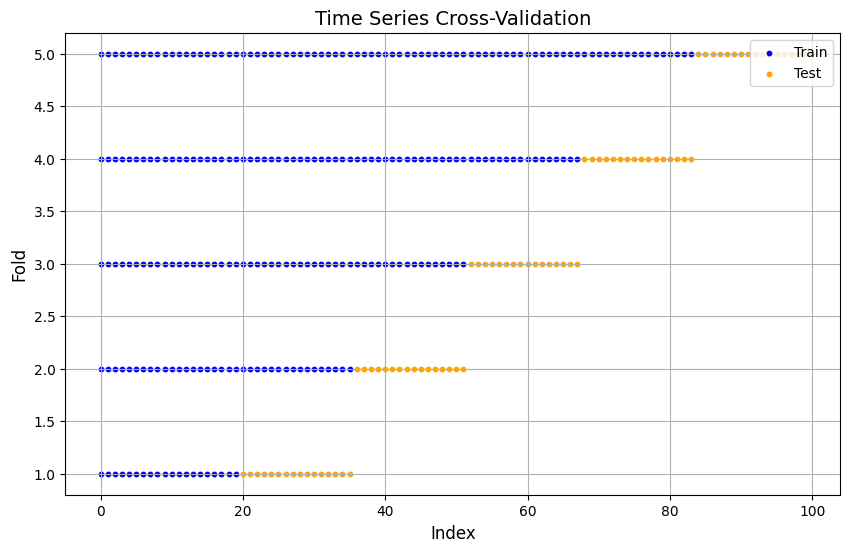

In [135]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [218]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_ABEV):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


Window 1 Accuracy: 0.6056
Window 2 Accuracy: 0.6333
Window 3 Accuracy: 0.8222
Window 4 Accuracy: 0.7500
Window 5 Accuracy: 0.7778
Window 6 Accuracy: 0.4556
Window 7 Accuracy: 0.7944
Window 8 Accuracy: 0.6444
Window 9 Accuracy: 0.6389
Window 10 Accuracy: 0.8667
Window 11 Accuracy: 0.6556
Window 12 Accuracy: 0.7667
Window 13 Accuracy: 0.7278
Window 14 Accuracy: 0.5500
Window 15 Accuracy: 0.6611
Window 16 Accuracy: 0.6389
Window 17 Accuracy: 0.7611
Window 18 Accuracy: 0.6667
Window 19 Accuracy: 0.6278
Window 20 Accuracy: 0.7444
Window 21 Accuracy: 0.8278
Window 22 Accuracy: 0.6167
Window 23 Accuracy: 0.6944
Window 24 Accuracy: 0.6444
Window 25 Accuracy: 0.7778
Window 26 Accuracy: 0.6944
Window 27 Accuracy: 0.6722
Window 28 Accuracy: 0.8056
Window 29 Accuracy: 0.5556

Walk-Forward Validation with Rolling Windows Results:
Average Accuracy: 0.6923
Standard Deviation: 0.0930


In [264]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_ABEV) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Ambev.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.91
  Accuracy with Verify: 0.47
Window 2:
  Accuracy with Y_test (Prediction): 0.89
  Accuracy with Verify: 0.43
Window 3:
  Accuracy with Y_test (Prediction): 0.94
  Accuracy with Verify: 0.58
Window 4:
  Accuracy with Y_test (Prediction): 0.96
  Accuracy with Verify: 0.46
Window 5:
  Accuracy with Y_test (Prediction): 0.92
  Accuracy with Verify: 0.51
Window 6:
  Accuracy with Y_test (Prediction): 0.94
  Accuracy with Verify: 0.65
Window 7:
  Accuracy with Y_test (Prediction): 0.92
  Accuracy with Verify: 0.53
Window 8:
  Accuracy with Y_test (Prediction): 0.92
  Accuracy with Verify: 0.57
Window 9:
  Accuracy with Y_test (Prediction): 0.93
  Accuracy with Verify: 0.42
Window 10:
  Accuracy with Y_test (Prediction): 0.95
  Accuracy with Verify: 0.57
Window 11:
  Accuracy with Y_test (Prediction): 0.90
  Accuracy with Verify: 0.47
Window 12:
  Accuracy with Y_test (Prediction): 0.84
  Accuracy with Verify: 0.45
Window 13:
  Accuracy wit

#### Outras métricas de acurácia.

In [21]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.822055,0.580531,0.680498,565.000000
Up Day,0.630841,0.850840,0.724508,476.000000
accuracy,0.704131,0.704131,0.704131,0.704131
macro avg,0.726448,0.715686,0.702503,1041.000000
weighted avg,0.734622,0.704131,0.700622,1041.000000


Accuracy: 0.7041306436119116
Precision: 0.6308411214953271
Recall: 0.8508403361344538
Specificity: 0.5805309734513274


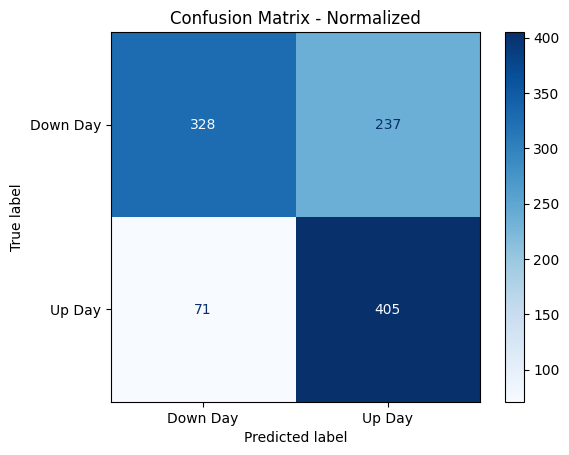

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


In [1]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Ambev, X_test, y_test)
plt.show()


NameError: name 'RocCurveDisplay' is not defined

#### Salvar modelo aprendido para AMBEV.

In [55]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Ambev, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl']

#### Carregar modelo. Geralmente carrego do modelo aprendido geral.

In [148]:
# Carregar o modelo salvo
rand_frst_clf_Ambev = joblib.load('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

#### Split normal sem cross-validation.

In [266]:
# Grab our X & Y Columns.
X_Cols = price_data_ABEV[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Ambev.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Ambev.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Ambev.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  84.80392156862744


In [147]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.753817,0.663866,0.705987,595.000000
Up Day,0.778761,0.845138,0.810593,833.000000
accuracy,0.769608,0.769608,0.769608,0.769608
macro avg,0.766289,0.754502,0.758290,1428.000000
weighted avg,0.768368,0.769608,0.767007,1428.000000


#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [269]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_ABEV['Prediction'] = np.NaN  # Inicializando a coluna
price_data_ABEV['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_ABEV['Match'] = (price_data_ABEV['Prediction'] == price_data_ABEV['Verify']).astype(int)
overall_accuracy = price_data_ABEV['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_ABEV[price_data_ABEV['Date'] >= price_data_ABEV['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 66.77%

Precisão do modelo nos últimos 30 dias: 55.00%


#### Plotagem:

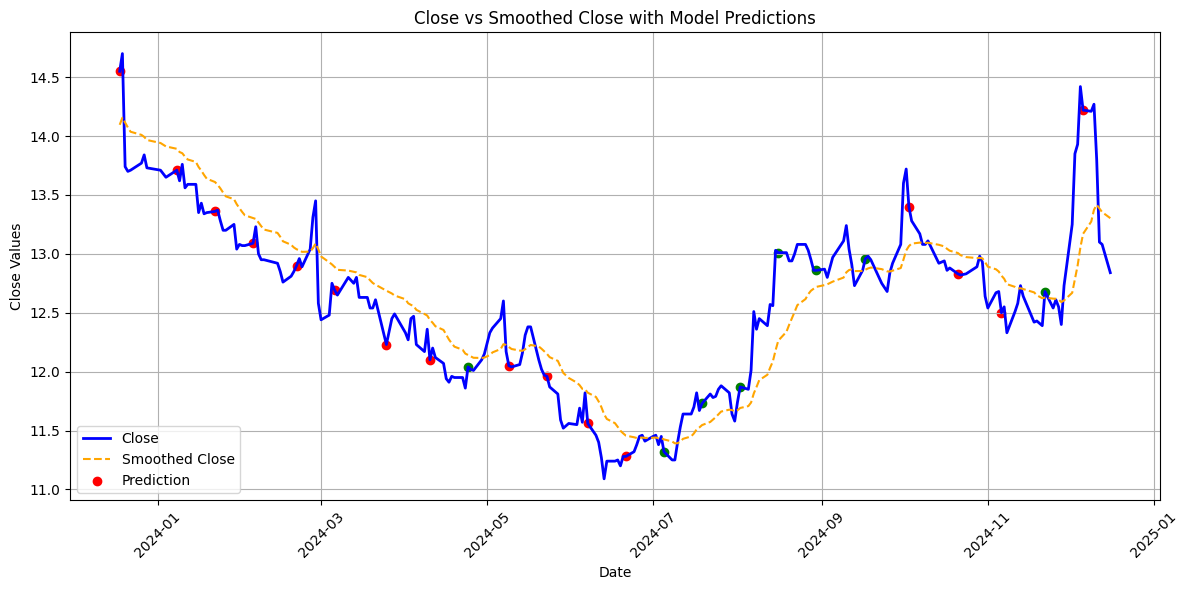

In [223]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ABEV3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Ambev.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Ambev.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### ITAÚ

#### Time series Cross-Validation

In [224]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]
price_data_Itau.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
17830,2001-01-12,3.129443,3.129443,3.046653,3.080100,1.682505,49788916,ITUB4.SA,-0.049343,3.039109,1.0,3.080100,1.0,3.129443,3.128212,0.049343,0.000000,54.433299,2.790006,3.228790,56.771310,-43.228690,0.011519,0.007955,0.030898,653169644,1
17831,2001-01-15,3.046653,3.112885,3.046653,3.112885,1.700415,7959945,ITUB4.SA,0.032785,3.046487,1.0,3.112885,-1.0,3.079769,3.123367,0.000000,0.032785,59.382961,2.790006,3.228790,58.452674,-41.547326,0.012869,0.008938,0.032845,661129589,0
17832,2001-01-16,3.112885,3.146001,3.096327,3.129443,1.709460,26138577,ITUB4.SA,0.016558,3.054783,1.0,3.129443,-1.0,3.088048,3.119835,0.000000,0.016558,61.800980,2.790006,3.228790,60.343261,-39.656739,0.014234,0.009997,0.031102,687268166,0
17833,2001-01-17,3.129443,3.179117,3.104606,3.154280,1.723027,52977726,ITUB4.SA,0.024837,3.064732,1.0,3.154280,-1.0,3.030096,3.110862,0.000000,0.024837,65.369227,2.831401,3.228790,58.716078,-41.283922,0.015714,0.011141,0.028669,740245892,0
17834,2001-01-18,3.154280,3.261906,3.154280,3.261906,1.781816,141660459,ITUB4.SA,0.107626,3.084450,1.0,3.261906,-1.0,3.046653,3.104441,0.000000,0.107626,76.394363,2.864351,3.261906,55.363083,-44.636917,0.017898,0.012492,0.029533,881906351,0


In [225]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.6487603305785123

Fold 2:
Accuracy for fold 2: 0.59400826446281

Fold 3:
Accuracy for fold 3: 0.7128099173553719

Fold 4:
Accuracy for fold 4: 0.7138429752066116

Fold 5:
Accuracy for fold 5: 0.7138429752066116

                precision    recall  f1-score     support  accuracy
1 Down Day       0.577540  0.292683  0.388489  369.000000  0.648760
  Up Day         0.665813  0.868114  0.753623  599.000000  0.648760
  accuracy       0.648760  0.648760  0.648760    0.648760  0.648760
  macro avg      0.621677  0.580398  0.571056  968.000000  0.648760
  weighted avg   0.632164  0.648760  0.614435  968.000000  0.648760
2 Down Day       0.507911  0.796526  0.620290  403.000000  0.594008
  Up Day         0.755952  0.449558  0.563818  565.000000  0.594008
  accuracy       0.594008  0.594008  0.594008    0.594008  0.594008
  macro avg      0.631932  0.623042  0.592054  968.000000  0.594008
  weighted avg   0.652687  0.594008  0.587328  968.000000  0.594008
3 Down Da

In [226]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Variável adicional de verificação
verify = price_data_Itau['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.65
  Accuracy with Verify: 0.49
Fold 2:
  Accuracy with Y_test (Prediction): 0.59
  Accuracy with Verify: 0.52
Fold 3:
  Accuracy with Y_test (Prediction): 0.71
  Accuracy with Verify: 0.51
Fold 4:
  Accuracy with Y_test (Prediction): 0.71
  Accuracy with Verify: 0.55
Fold 5:
  Accuracy with Y_test (Prediction): 0.71
  Accuracy with Verify: 0.55

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.68
  Média da acurácia com Verify: 0.53

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0     1.0
2            1.0              1.0     1.0
3            1.0              1.0     1.0
4            1.0              1.0     1.0
...          ...              ...     ...
4835        -1.0             -1.0    -1.0
4836        -1.0             -1.0    -1.0
4837        -1.0             -1.0    -1.0
4838        -1.0             -1.0    -1.0
4839        -1.0    

#### Plotagem Time-Series Cross Validation

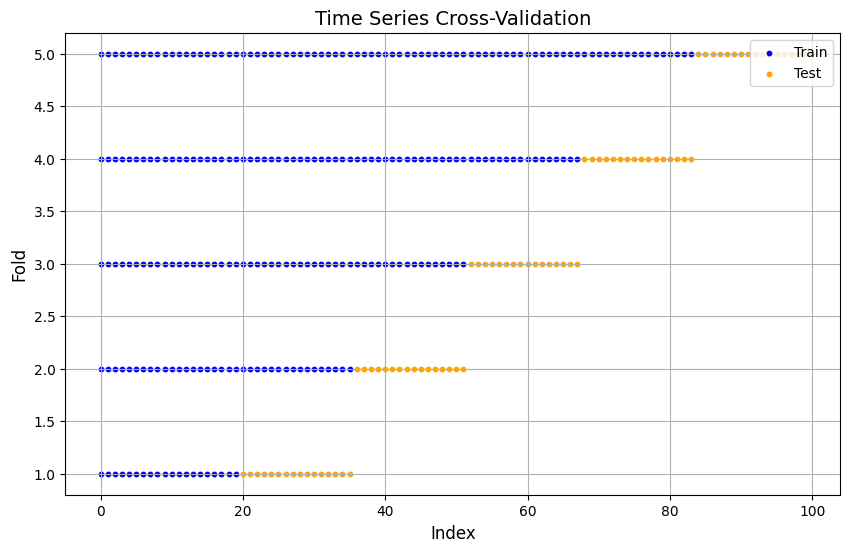

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [227]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Itau):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


Window 1 Accuracy: 0.7167
Window 2 Accuracy: 0.6444
Window 3 Accuracy: 0.7111
Window 4 Accuracy: 0.7056
Window 5 Accuracy: 0.7222
Window 6 Accuracy: 0.6333
Window 7 Accuracy: 0.7278
Window 8 Accuracy: 0.7500
Window 9 Accuracy: 0.5944
Window 10 Accuracy: 0.3500
Window 11 Accuracy: 0.6667
Window 12 Accuracy: 0.5056
Window 13 Accuracy: 0.6889
Window 14 Accuracy: 0.8167
Window 15 Accuracy: 0.6611
Window 16 Accuracy: 0.6611
Window 17 Accuracy: 0.6056
Window 18 Accuracy: 0.5222
Window 19 Accuracy: 0.7778
Window 20 Accuracy: 0.7278
Window 21 Accuracy: 0.7778
Window 22 Accuracy: 0.7611
Window 23 Accuracy: 0.8056
Window 24 Accuracy: 0.5944
Window 25 Accuracy: 0.8056
Window 26 Accuracy: 0.7111
Window 27 Accuracy: 0.7278
Window 28 Accuracy: 0.6833
Window 29 Accuracy: 0.6889
Window 30 Accuracy: 0.6833

Walk-Forward Validation with Rolling Windows Results:
Average Accuracy: 0.6809
Standard Deviation: 0.0970


In [228]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Variável adicional de verificação
verify = price_data_Itau['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Itau) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Itau.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Itau.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.72
  Accuracy with Verify: 0.48
Window 2:
  Accuracy with Y_test (Prediction): 0.64
  Accuracy with Verify: 0.46
Window 3:
  Accuracy with Y_test (Prediction): 0.71
  Accuracy with Verify: 0.55
Window 4:
  Accuracy with Y_test (Prediction): 0.71
  Accuracy with Verify: 0.56
Window 5:
  Accuracy with Y_test (Prediction): 0.72
  Accuracy with Verify: 0.68
Window 6:
  Accuracy with Y_test (Prediction): 0.63
  Accuracy with Verify: 0.46
Window 7:
  Accuracy with Y_test (Prediction): 0.73
  Accuracy with Verify: 0.58
Window 8:
  Accuracy with Y_test (Prediction): 0.75
  Accuracy with Verify: 0.48
Window 9:
  Accuracy with Y_test (Prediction): 0.59
  Accuracy with Verify: 0.44
Window 10:
  Accuracy with Y_test (Prediction): 0.35
  Accuracy with Verify: 0.42
Window 11:
  Accuracy with Y_test (Prediction): 0.67
  Accuracy with Verify: 0.51
Window 12:
  Accuracy with Y_test (Prediction): 0.51
  Accuracy with Verify: 0.43
Window 13:
  Accuracy wit

#### Outras métricas de acurácia.

In [ ]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.822055,0.580531,0.680498,565.000000
Up Day,0.630841,0.850840,0.724508,476.000000
accuracy,0.704131,0.704131,0.704131,0.704131
macro avg,0.726448,0.715686,0.702503,1041.000000
weighted avg,0.734622,0.704131,0.700622,1041.000000


Accuracy: 0.7041306436119116
Precision: 0.6308411214953271
Recall: 0.8508403361344538
Specificity: 0.5805309734513274


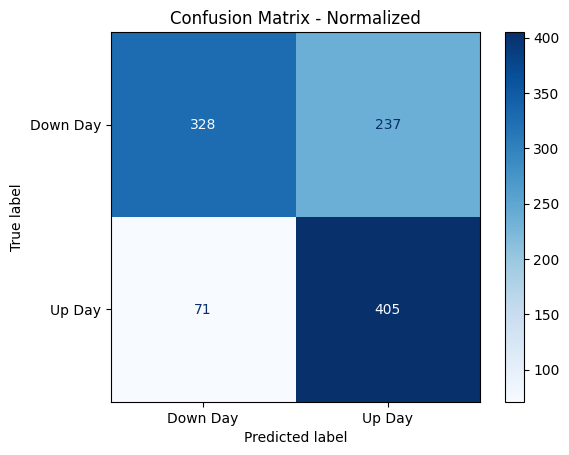

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


In [ ]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Ambev, X_test, y_test)
plt.show()


NameError: name 'RocCurveDisplay' is not defined

#### Salvar modelo aprendido para ITAU.

In [ ]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Itau, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl']

#### Split normal sem cross-validation.

In [229]:
# Grab our X & Y Columns.
X_Cols = price_data_Itau[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Itau.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Itau.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Itau.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  84.15977961432507


In [ ]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.797364,0.780645,0.788916,620.000000
Up Day,0.857741,0.869565,0.863612,943.000000
accuracy,0.834293,0.834293,0.834293,0.834293
macro avg,0.827552,0.825105,0.826264,1563.000000
weighted avg,0.833791,0.834293,0.833982,1563.000000


#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [230]:
import warnings

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Selecionar colunas como array NumPy
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values


price_data_Itau['Prediction'] = np.NaN
# Gerar previsões e atualizar a coluna 'Prediction'
price_data_Itau['Prediction'] = rand_frst_clf_Itau.predict(X_Cols)


price_data_Itau['Match'] = (price_data_Itau['Prediction'] == price_data_Itau['Verify']).astype(int)
accuracy = price_data_Itau['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo: {accuracy:.2%}")



Precisão do modelo: 66.92%


In [231]:
from datetime import timedelta

# Filtrar últimos 30 dias
last_30_days = price_data_Itau[price_data_Itau['Date'] >= price_data_Itau['Date'].max() - timedelta(days=30)]

# Selecionar colunas como array NumPy
X_Cols = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões e atualizar a coluna 'Prediction' para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Itau.predict(X_Cols)

# Comparar valores e calcular a precisão
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)  # 1 para igual, 0 para diferente
accuracy = last_30_days['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy:.2%}")



Precisão do modelo nos últimos 30 dias: 100.00%


#### Plotagem:

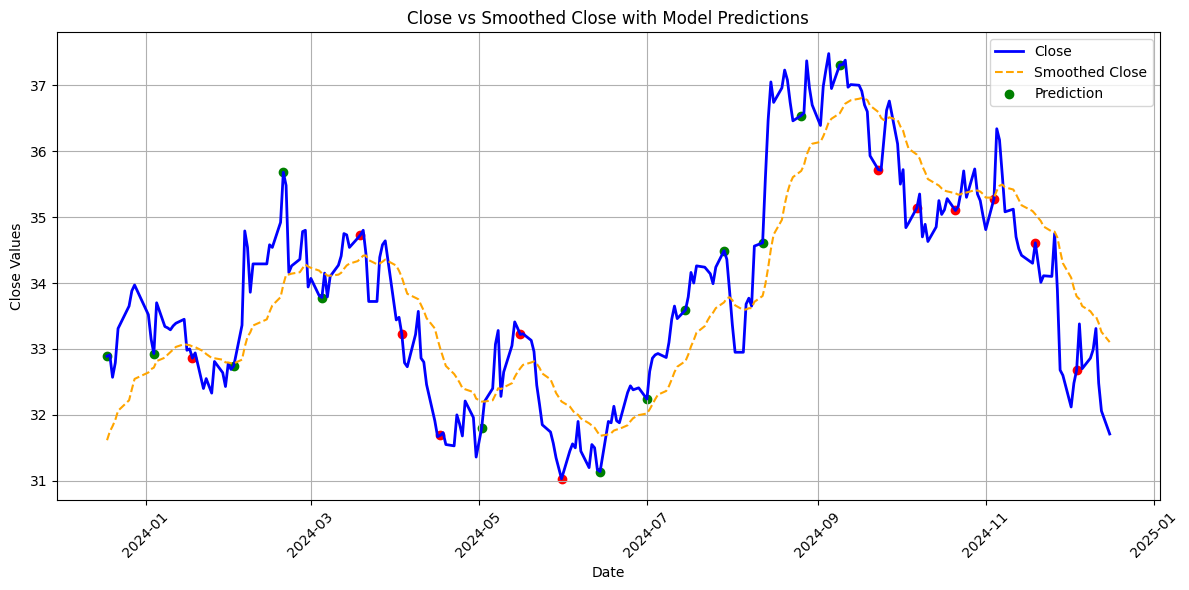

In [280]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ITUB4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### MAGALU

#### Time series Cross-Validation

In [282]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]
price_data_Magalu.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
23661,2011-05-23,4.606467,4.641542,4.545086,4.641542,4.274924,935719,MGLU3.SA,-0.017537,4.731706,-1.0,4.641542,1.0,4.881218,4.726884,0.017537,0.000000,32.626397,4.533395,4.878295,57.498153,-42.501847,-0.008123,-0.032761,-0.013872,-13212506,0
23662,2011-05-24,4.662002,4.676616,4.533395,4.580161,4.218390,3585840,MGLU3.SA,-0.061381,4.716552,1.0,4.580161,1.0,4.878295,4.742025,0.061381,0.000000,25.316822,4.533395,4.878295,53.104275,-46.895725,-0.010219,-0.028252,-0.015133,-16798346,1
23663,2011-05-25,4.574315,4.574315,4.439862,4.442785,4.091866,1985366,MGLU3.SA,-0.137376,4.689175,1.0,4.442785,1.0,4.846144,4.752437,0.137376,0.000000,16.037903,4.439862,4.822760,65.112083,-34.887917,-0.013341,-0.025270,-0.020942,-18783712,1
23664,2011-05-26,4.436940,4.603544,4.436940,4.597698,4.234543,1263135,MGLU3.SA,0.154913,4.680027,1.0,4.597698,1.0,4.998134,4.777007,0.000000,0.154913,43.149183,4.436940,4.822760,63.005301,-36.994699,-0.016122,-0.023440,-0.023054,-20046847,1
23665,2011-05-27,4.556778,4.647387,4.536318,4.618158,4.253386,1778037,MGLU3.SA,0.020460,4.673840,-1.0,4.618158,1.0,5.012748,4.800581,0.000000,0.020460,45.815425,4.436940,4.822760,61.401720,-38.598280,-0.018445,-0.022441,-0.024110,-21824884,0


In [234]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Magalu.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Magalu.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy:.2f}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.75

Fold 2:
Accuracy for fold 2: 0.78

Fold 3:
Accuracy for fold 3: 0.67

Fold 4:
Accuracy for fold 4: 0.76

Fold 5:
Accuracy for fold 5: 0.71

                precision    recall  f1-score     support  accuracy
1 Down Day       0.890282  0.737662  0.806818  385.000000  0.752277
  Up Day         0.560870  0.786585  0.654822  164.000000  0.752277
  accuracy       0.752277  0.752277  0.752277    0.752277  0.752277
  macro avg      0.725576  0.762124  0.730820  549.000000  0.752277
  weighted avg   0.791878  0.752277  0.761413  549.000000  0.752277
2 Down Day       0.282609  0.650000  0.393939   60.000000  0.781421
  Up Day         0.948905  0.797546  0.866667  489.000000  0.781421
  accuracy       0.781421  0.781421  0.781421    0.781421  0.781421
  macro avg      0.615757  0.723773  0.630303  549.000000  0.781421
  weighted avg   0.876086  0.781421  0.815002  549.000000  0.781421
3 Down Day       0.382353  0.728000  0.501377  125.000000  0.670310
  Up Day 

In [235]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Variável adicional de verificação
verify = price_data_Magalu['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Magalu.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Magalu.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.75
  Accuracy with Verify: 0.55
Fold 2:
  Accuracy with Y_test (Prediction): 0.78
  Accuracy with Verify: 0.60
Fold 3:
  Accuracy with Y_test (Prediction): 0.67
  Accuracy with Verify: 0.56
Fold 4:
  Accuracy with Y_test (Prediction): 0.76
  Accuracy with Verify: 0.52
Fold 5:
  Accuracy with Y_test (Prediction): 0.71
  Accuracy with Verify: 0.47

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.73
  Média da acurácia com Verify: 0.54

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0     1.0
2            1.0              1.0     1.0
3            1.0              1.0     1.0
4            1.0              1.0     1.0
...          ...              ...     ...
2740         1.0             -1.0    -1.0
2741         1.0             -1.0    -1.0
2742         1.0             -1.0    -1.0
2743         1.0             -1.0    -1.0
2744         1.0    

#### Plotagem Time-Series Cross Validation

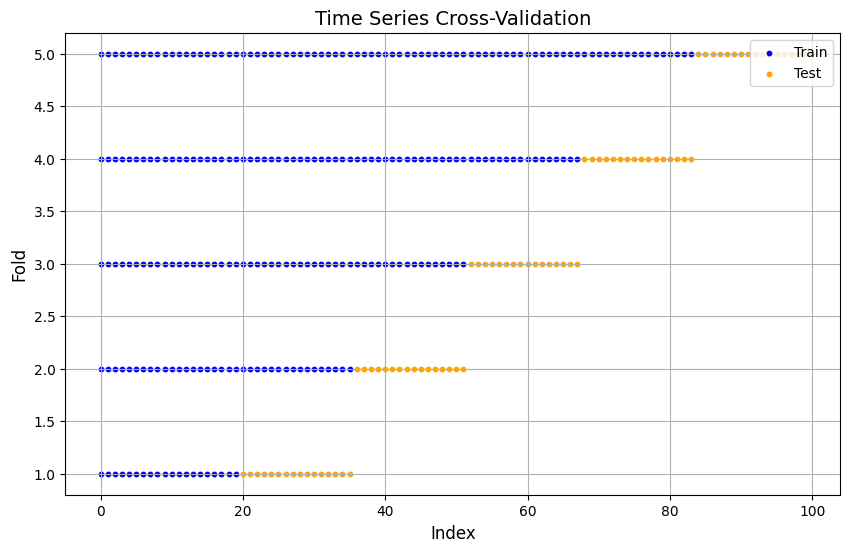

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [236]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Magalu):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Magalu.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Magalu.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


Window 1 Accuracy: 0.6889
Window 2 Accuracy: 0.8056
Window 3 Accuracy: 0.7722
Window 4 Accuracy: 0.7222
Window 5 Accuracy: 0.7111
Window 6 Accuracy: 0.9444
Window 7 Accuracy: 0.7333
Window 8 Accuracy: 0.3167
Window 9 Accuracy: 0.5444
Window 10 Accuracy: 0.7667
Window 11 Accuracy: 0.7333
Window 12 Accuracy: 0.7389
Window 13 Accuracy: 0.7778
Window 14 Accuracy: 0.7278
Window 15 Accuracy: 0.5833
Window 16 Accuracy: 0.6056

Walk-Forward Validation with Rolling Windows Results:
Average Accuracy: 0.6983
Standard Deviation: 0.1336


In [238]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Variável adicional de verificação
verify = price_data_Magalu['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Magalu) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Magalu.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Magalu.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.69
  Accuracy with Verify: 0.63
Window 2:
  Accuracy with Y_test (Prediction): 0.81
  Accuracy with Verify: 0.57
Window 3:
  Accuracy with Y_test (Prediction): 0.77
  Accuracy with Verify: 0.48
Window 4:
  Accuracy with Y_test (Prediction): 0.72
  Accuracy with Verify: 0.75
Window 5:
  Accuracy with Y_test (Prediction): 0.71
  Accuracy with Verify: 0.57
Window 6:
  Accuracy with Y_test (Prediction): 0.94
  Accuracy with Verify: 0.73
Window 7:
  Accuracy with Y_test (Prediction): 0.73
  Accuracy with Verify: 0.56
Window 8:
  Accuracy with Y_test (Prediction): 0.32
  Accuracy with Verify: 0.35
Window 9:
  Accuracy with Y_test (Prediction): 0.54
  Accuracy with Verify: 0.40
Window 10:
  Accuracy with Y_test (Prediction): 0.77
  Accuracy with Verify: 0.64
Window 11:
  Accuracy with Y_test (Prediction): 0.73
  Accuracy with Verify: 0.52
Window 12:
  Accuracy with Y_test (Prediction): 0.74
  Accuracy with Verify: 0.49
Window 13:
  Accuracy wit

#### Outras métricas de acurácia.

In [ ]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

Accuracy: 0.7041306436119116
Precision: 0.6308411214953271
Recall: 0.8508403361344538
Specificity: 0.5805309734513274


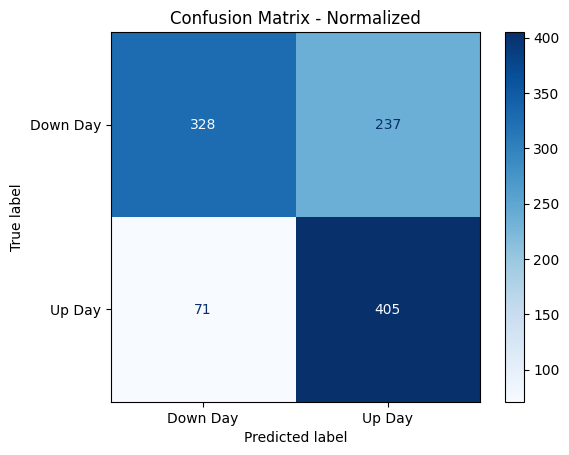

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


In [ ]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Magalu, X_test, y_test)
plt.show()


NameError: name 'RocCurveDisplay' is not defined

#### Salvar modelo aprendido para MAGALU.

In [284]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Maglu, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl']

#### Split normal sem cross-validation.

In [283]:
# Grab our X & Y Columns.
X_Cols = price_data_Magalu[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Magalu.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Magalu.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Magalu.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  87.86407766990291


In [ ]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

#### Utilizando a verificação da predição com o preço real e não suavizado. Manter cross-validation.

In [287]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Magalu['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Magalu['Prediction'] = rand_frst_clf_Magalu.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Magalu['Match'] = (price_data_Magalu['Prediction'] == price_data_Magalu['Verify']).astype(int)
overall_accuracy = price_data_Magalu['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Magalu[price_data_Magalu['Date'] >= price_data_Magalu['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Magalu.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 70.26%

Precisão do modelo nos últimos 30 dias: 90.00%


#### Plotagem:

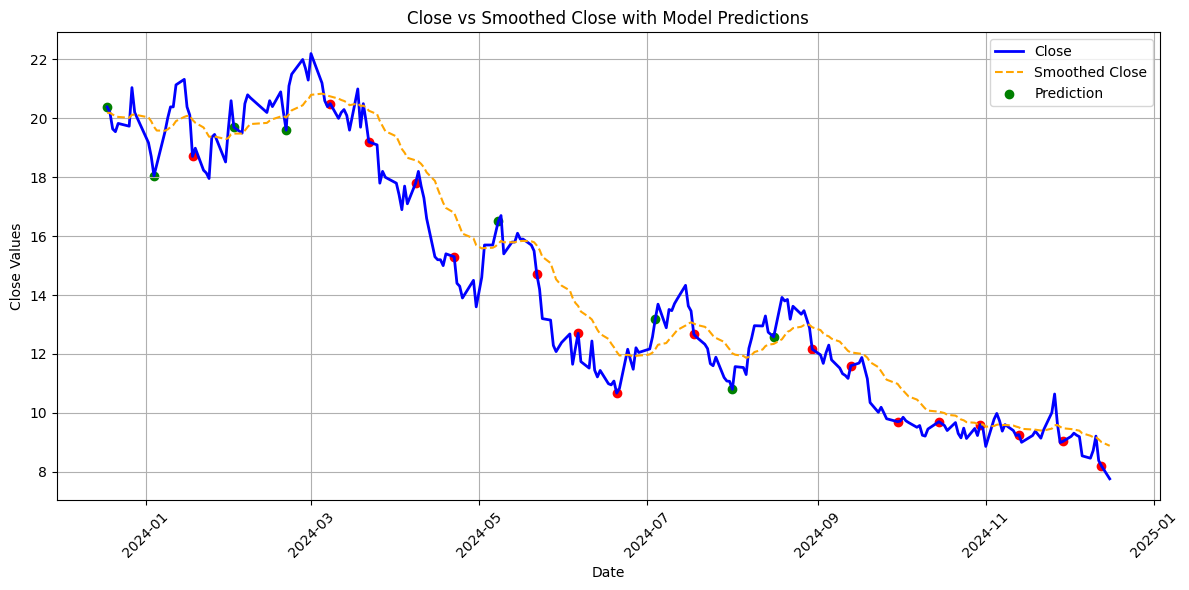

In [288]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'MGLU3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Magalu.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Magalu.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Petrobrás.

#### Time series Cross-Validation

In [289]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]
price_data_Petro.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
11765,2000-01-20,5.313,5.313,5.313,5.313,1.157734,26268160000,PETR4.SA,-0.012,5.524186,-1.0,5.313,1.0,5.588,5.374198,0.012,0.000,27.170336,5.313,5.875,37.577523,-62.422477,-0.033294,-0.038382,-0.038762,-336407040000,0
11766,2000-01-21,5.200,5.200,5.200,5.200,1.133111,17512960000,PETR4.SA,-0.113,5.491767,-1.0,5.200,1.0,5.625,5.399278,0.113,0.000,20.428414,5.200,5.613,70.645841,-29.354159,-0.037668,-0.038239,-0.042170,-353920000000,0
11767,2000-01-24,5.163,5.163,5.163,5.163,1.125048,18385920000,PETR4.SA,-0.037,5.458890,-1.0,5.163,1.0,5.750,5.434350,0.037,0.000,18.677468,5.163,5.613,65.753448,-34.246552,-0.042507,-0.039093,-0.043591,-372305920000,0
11768,2000-01-26,5.225,5.225,5.225,5.225,1.138559,25917440000,PETR4.SA,0.062,5.435501,1.0,5.225,1.0,5.463,5.437215,0.000,0.062,30.238440,5.163,5.613,60.555877,-39.444123,-0.047117,-0.040698,-0.043925,-398223360000,1
11769,2000-01-27,5.188,5.188,5.188,5.188,1.130496,38379520000,PETR4.SA,-0.037,5.410751,1.0,5.188,1.0,5.288,5.422294,0.037,0.000,27.542316,5.163,5.613,55.055847,-44.944153,-0.051630,-0.042884,-0.042210,-436602880000,1


In [247]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy:.2f}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.73

Fold 2:
Accuracy for fold 2: 0.58

Fold 3:
Accuracy for fold 3: 0.79

Fold 4:
Accuracy for fold 4: 0.76

Fold 5:
Accuracy for fold 5: 0.77

                precision    recall  f1-score      support  accuracy
1 Down Day       0.578732  0.806268  0.673810   351.000000  0.727905
  Up Day         0.868726  0.685976  0.766610   656.000000  0.727905
  accuracy       0.727905  0.727905  0.727905     0.727905  0.727905
  macro avg      0.723729  0.746122  0.720210  1007.000000  0.727905
  weighted avg   0.767646  0.727905  0.734263  1007.000000  0.727905
2 Down Day       0.674487  0.428305  0.523918   537.000000  0.584906
  Up Day         0.539039  0.763830  0.632042   470.000000  0.584906
  accuracy       0.584906  0.584906  0.584906     0.584906  0.584906
  macro avg      0.606763  0.596068  0.577980  1007.000000  0.584906
  weighted avg   0.611269  0.584906  0.574383  1007.000000  0.584906
3 Down Day       0.794179  0.767068  0.780388   498.000000  0.7864

In [248]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Variável adicional de verificação
verify = price_data_Petro['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.73
  Accuracy with Verify: 0.53
Fold 2:
  Accuracy with Y_test (Prediction): 0.58
  Accuracy with Verify: 0.49
Fold 3:
  Accuracy with Y_test (Prediction): 0.79
  Accuracy with Verify: 0.53
Fold 4:
  Accuracy with Y_test (Prediction): 0.76
  Accuracy with Verify: 0.55
Fold 5:
  Accuracy with Y_test (Prediction): 0.77
  Accuracy with Verify: 0.45

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.73
  Média da acurácia com Verify: 0.51

Comparação:
      Prediction  Y_Test (Actual)  Verify
0           -1.0              1.0     1.0
1           -1.0              1.0     1.0
2           -1.0             -1.0     1.0
3           -1.0              1.0     1.0
4            1.0              1.0     1.0
...          ...              ...     ...
5030         1.0             -1.0    -1.0
5031         1.0             -1.0    -1.0
5032        -1.0             -1.0    -1.0
5033        -1.0             -1.0    -1.0
5034        -1.0    

#### Plotagem Time-Series Cross Validation

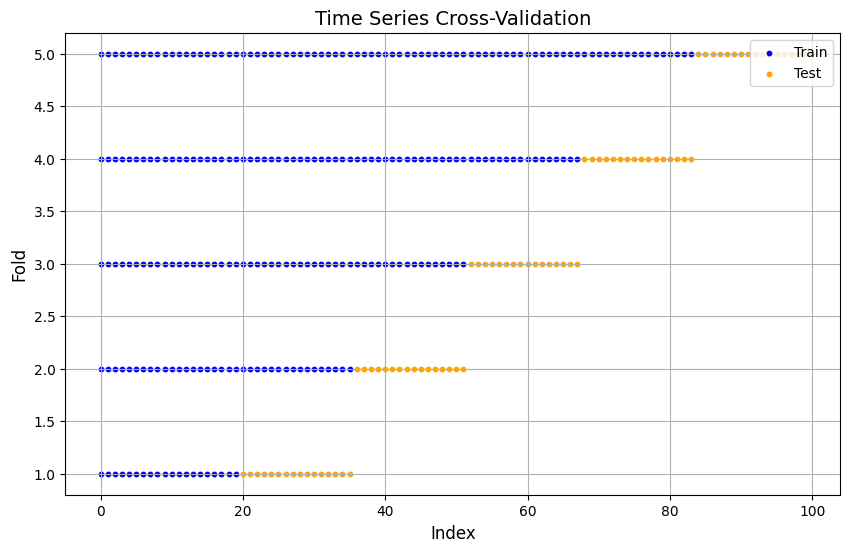

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [249]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Petro):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


Window 1 Accuracy: 0.7167
Window 2 Accuracy: 0.6389
Window 3 Accuracy: 0.6833
Window 4 Accuracy: 0.6000
Window 5 Accuracy: 0.7056
Window 6 Accuracy: 0.7556
Window 7 Accuracy: 0.6222
Window 8 Accuracy: 0.8667
Window 9 Accuracy: 0.6889
Window 10 Accuracy: 0.4778
Window 11 Accuracy: 0.6667
Window 12 Accuracy: 0.8278
Window 13 Accuracy: 0.6444
Window 14 Accuracy: 0.6833
Window 15 Accuracy: 0.5778
Window 16 Accuracy: 0.6500
Window 17 Accuracy: 0.7278
Window 18 Accuracy: 0.4167
Window 19 Accuracy: 0.7000
Window 20 Accuracy: 0.6556
Window 21 Accuracy: 0.7444
Window 22 Accuracy: 0.8444
Window 23 Accuracy: 0.6389
Window 24 Accuracy: 0.6333
Window 25 Accuracy: 0.7500
Window 26 Accuracy: 0.8000
Window 27 Accuracy: 0.6111
Window 28 Accuracy: 0.5333
Window 29 Accuracy: 0.6889
Window 30 Accuracy: 0.6667
Window 31 Accuracy: 0.7778

Walk-Forward Validation with Rolling Windows Results:
Average Accuracy: 0.6772
Standard Deviation: 0.0971


In [250]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Variável adicional de verificação
verify = price_data_Petro['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Petro) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Petro.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Petro.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.72
  Accuracy with Verify: 0.49
Window 2:
  Accuracy with Y_test (Prediction): 0.64
  Accuracy with Verify: 0.53
Window 3:
  Accuracy with Y_test (Prediction): 0.68
  Accuracy with Verify: 0.47
Window 4:
  Accuracy with Y_test (Prediction): 0.60
  Accuracy with Verify: 0.43
Window 5:
  Accuracy with Y_test (Prediction): 0.71
  Accuracy with Verify: 0.60
Window 6:
  Accuracy with Y_test (Prediction): 0.76
  Accuracy with Verify: 0.66
Window 7:
  Accuracy with Y_test (Prediction): 0.62
  Accuracy with Verify: 0.50
Window 8:
  Accuracy with Y_test (Prediction): 0.87
  Accuracy with Verify: 0.66
Window 9:
  Accuracy with Y_test (Prediction): 0.69
  Accuracy with Verify: 0.54
Window 10:
  Accuracy with Y_test (Prediction): 0.48
  Accuracy with Verify: 0.58
Window 11:
  Accuracy with Y_test (Prediction): 0.67
  Accuracy with Verify: 0.42
Window 12:
  Accuracy with Y_test (Prediction): 0.83
  Accuracy with Verify: 0.59
Window 13:
  Accuracy wit

#### Outras métricas de acurácia.

In [ ]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


In [ ]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Petro, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [251]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Petro, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl']

#### Split normal sem cross-validation.

In [290]:
# Grab our X & Y Columns.
X_Cols = price_data_Petro[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Petro.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Petro.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Petro.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  86.10191925876902


In [ ]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [291]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Petro['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Petro['Prediction'] = rand_frst_clf_Petro.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Petro['Match'] = (price_data_Petro['Prediction'] == price_data_Petro['Verify']).astype(int)
overall_accuracy = price_data_Petro['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Petro[price_data_Petro['Date'] >= price_data_Petro['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Petro.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 67.00%

Precisão do modelo nos últimos 30 dias: 55.00%


#### Plotagem:

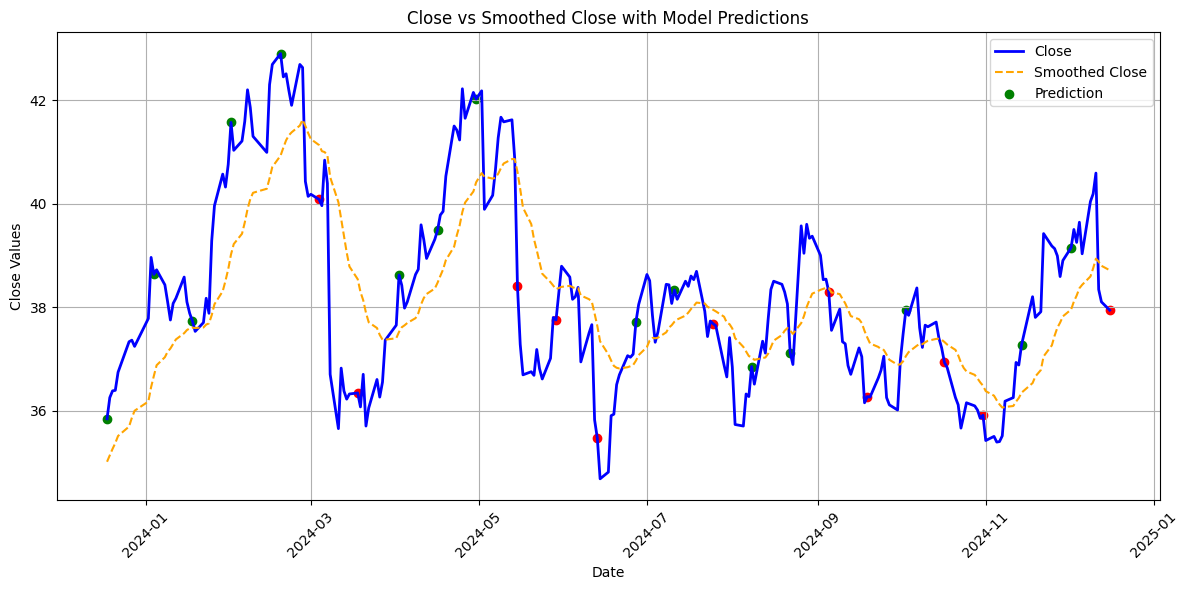

In [292]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'PETR4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Petro.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Petro.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Vale.

#### Time series Cross-Validation

In [270]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]
price_data_Vale.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
5748,2000-01-21,4.000000,4.000000,3.916666,3.916666,1.668742,144000,VALE3.SA,-0.083334,3.816120,1.0,3.916666,1.0,4.000000,3.950014,0.083334,0.000000,55.357618,3.375000,4.166666,55.720498,-44.279502,0.039181,0.032900,0.082815,21388800,1
5749,2000-01-26,3.966666,3.966666,3.966666,3.966666,1.690045,196800,VALE3.SA,0.050000,3.831175,1.0,3.966666,-1.0,3.790833,3.934096,0.000000,0.050000,60.156173,3.375000,4.166666,57.622130,-42.377870,0.042333,0.034787,0.077384,21585600,0
5750,2000-01-28,4.000000,4.000000,4.000000,4.000000,1.704248,211200,VALE3.SA,0.033334,3.848057,1.0,4.000000,-1.0,3.741666,3.914853,0.000000,0.033334,63.199074,3.375000,4.166666,59.754660,-40.245340,0.045218,0.036873,0.072385,21796800,0
5751,2000-02-01,3.916666,3.916666,3.916666,3.916666,1.668742,148800,VALE3.SA,-0.083334,3.854918,1.0,3.916666,-1.0,3.833333,3.906701,0.083334,0.000000,51.789901,3.458333,4.166666,55.988524,-44.011476,0.047280,0.038954,0.061868,21945600,0
5752,2000-02-02,3.950000,3.950000,3.750000,3.750000,1.597732,739200,VALE3.SA,-0.166666,3.844426,1.0,3.750000,1.0,3.833333,3.899364,0.166666,0.000000,36.559368,3.750000,4.166666,22.662369,-77.337631,0.047618,0.040687,0.045926,21206400,1


In [271]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy:.2f}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.71

Fold 2:
Accuracy for fold 2: 0.76

Fold 3:
Accuracy for fold 3: 0.66

Fold 4:
Accuracy for fold 4: 0.79

Fold 5:
Accuracy for fold 5: 0.76

                precision    recall  f1-score     support  accuracy
1 Down Day       0.568389  0.556548  0.562406  336.000000  0.708709
  Up Day         0.777612  0.785822  0.781695  663.000000  0.708709
  accuracy       0.708709  0.708709  0.708709    0.708709  0.708709
  macro avg      0.673000  0.671185  0.672051  999.000000  0.708709
  weighted avg   0.707243  0.708709  0.707940  999.000000  0.708709
2 Down Day       0.809278  0.650104  0.721010  483.000000  0.756757
  Up Day         0.723404  0.856589  0.784383  516.000000  0.756757
  accuracy       0.756757  0.756757  0.756757    0.756757  0.756757
  macro avg      0.766341  0.753346  0.752697  999.000000  0.756757
  weighted avg   0.764923  0.756757  0.753744  999.000000  0.756757
3 Down Day       0.835777  0.498252  0.624315  572.000000  0.656657
  Up Day 

In [272]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Variável adicional de verificação
verify = price_data_Vale['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.71
  Accuracy with Verify: 0.56
Fold 2:
  Accuracy with Y_test (Prediction): 0.76
  Accuracy with Verify: 0.48
Fold 3:
  Accuracy with Y_test (Prediction): 0.66
  Accuracy with Verify: 0.49
Fold 4:
  Accuracy with Y_test (Prediction): 0.79
  Accuracy with Verify: 0.52
Fold 5:
  Accuracy with Y_test (Prediction): 0.76
  Accuracy with Verify: 0.51

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.73
  Média da acurácia com Verify: 0.51

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0     1.0
2            1.0              1.0     1.0
3            1.0              1.0    -1.0
4            1.0              1.0     1.0
...          ...              ...     ...
4990         1.0             -1.0    -1.0
4991         1.0             -1.0    -1.0
4992        -1.0             -1.0    -1.0
4993        -1.0             -1.0    -1.0
4994        -1.0    

#### Plotagem Time-Series Cross Validation

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [273]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Vale):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


Window 1 Accuracy: 0.7500
Window 2 Accuracy: 0.6667
Window 3 Accuracy: 0.4167
Window 4 Accuracy: 0.7778
Window 5 Accuracy: 0.6278
Window 6 Accuracy: 0.7833
Window 7 Accuracy: 0.6778
Window 8 Accuracy: 0.8000
Window 9 Accuracy: 0.5556
Window 10 Accuracy: 0.7444
Window 11 Accuracy: 0.8333
Window 12 Accuracy: 0.7889
Window 13 Accuracy: 0.7333
Window 14 Accuracy: 0.6333
Window 15 Accuracy: 0.5333
Window 16 Accuracy: 0.5778
Window 17 Accuracy: 0.7389
Window 18 Accuracy: 0.3444
Window 19 Accuracy: 0.7056
Window 20 Accuracy: 0.5889
Window 21 Accuracy: 0.6722
Window 22 Accuracy: 0.8611
Window 23 Accuracy: 0.7611
Window 24 Accuracy: 0.7722
Window 25 Accuracy: 0.8056
Window 26 Accuracy: 0.8167
Window 27 Accuracy: 0.6889
Window 28 Accuracy: 0.8056
Window 29 Accuracy: 0.8111
Window 30 Accuracy: 0.7778
Window 31 Accuracy: 0.7778

Walk-Forward Validation with Rolling Windows Results:
Average Accuracy: 0.7041
Standard Deviation: 0.1199


In [274]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Variável adicional de verificação
verify = price_data_Vale['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Vale) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Vale.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Vale.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.75
  Accuracy with Verify: 0.58
Window 2:
  Accuracy with Y_test (Prediction): 0.67
  Accuracy with Verify: 0.56
Window 3:
  Accuracy with Y_test (Prediction): 0.42
  Accuracy with Verify: 0.53
Window 4:
  Accuracy with Y_test (Prediction): 0.78
  Accuracy with Verify: 0.52
Window 5:
  Accuracy with Y_test (Prediction): 0.63
  Accuracy with Verify: 0.63
Window 6:
  Accuracy with Y_test (Prediction): 0.78
  Accuracy with Verify: 0.52
Window 7:
  Accuracy with Y_test (Prediction): 0.68
  Accuracy with Verify: 0.50
Window 8:
  Accuracy with Y_test (Prediction): 0.80
  Accuracy with Verify: 0.57
Window 9:
  Accuracy with Y_test (Prediction): 0.56
  Accuracy with Verify: 0.49
Window 10:
  Accuracy with Y_test (Prediction): 0.74
  Accuracy with Verify: 0.52
Window 11:
  Accuracy with Y_test (Prediction): 0.83
  Accuracy with Verify: 0.59
Window 12:
  Accuracy with Y_test (Prediction): 0.79
  Accuracy with Verify: 0.58
Window 13:
  Accuracy wit

#### Outras métricas de acurácia.

In [ ]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


In [ ]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Vale, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [277]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Vale, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl']

#### Split normal sem cross-validation.

In [276]:
# Grab our X & Y Columns.
X_Cols = price_data_Vale[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Vale.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Vale.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Vale.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  84.92328218812541


In [ ]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [278]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Vale['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Vale['Prediction'] = rand_frst_clf_Vale.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Vale['Match'] = (price_data_Vale['Prediction'] == price_data_Vale['Verify']).astype(int)
overall_accuracy = price_data_Vale['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Vale[price_data_Vale['Date'] >= price_data_Vale['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Vale.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 66.33%

Precisão do modelo nos últimos 30 dias: 60.00%


#### Plotagem:

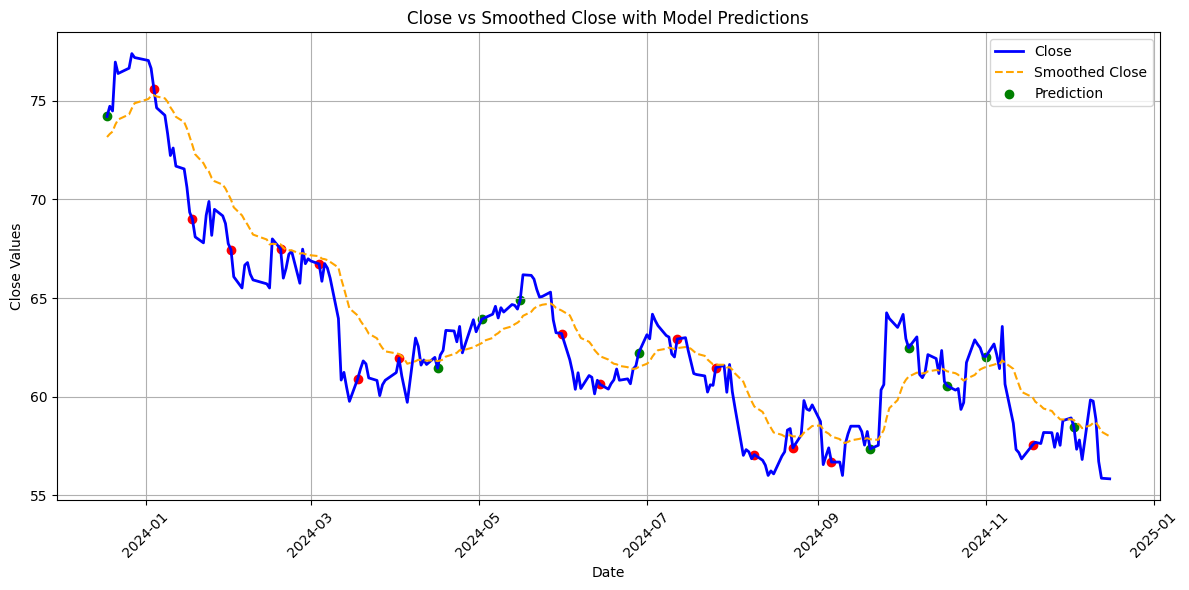

In [279]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'VALE3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Vale.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Vale.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()
